In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

plt.rcParams["figure.figsize"] = (8,5)


In [4]:
# (Lyft_take $, observed match-rate) pairs
data_points = [
    (8.0, 0.70),    # launch setting  : 35 – 27 = $8 take → 70 % match
    (4.0, 0.88),    # experiment      : 35 – 31 = $4 take → 88 % match
]
takes_obs, matches_obs = zip(*data_points)


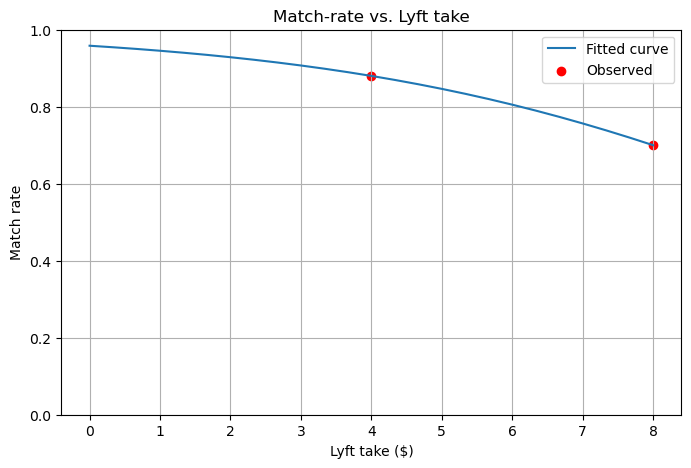

In [6]:
def logit(y): return np.log(y/(1-y))
(p1, m1), (p2, m2) = data_points         # two-point fit
b = (logit(m2) - logit(m1)) / (p2 - p1)  # slope
a = logit(m1) - b * p1                   # intercept

def match_rate(take):
    """Probability a rider is matched, given Lyft take ($)."""
    return 1 / (1 + np.exp(-(a + b * take)))

# Quick sanity plot
grid = np.linspace(0, 8, 25)
plt.plot(grid, match_rate(grid), label="Fitted curve")
plt.scatter(takes_obs, matches_obs, color="red", label="Observed")
plt.xlabel("Lyft take ($)"); plt.ylabel("Match rate"); plt.ylim(0,1)
plt.title("Match-rate vs. Lyft take"); plt.grid(True); plt.legend(); plt.show()


In [8]:
FARE                 = 35        # rider pays
GOOD_RIDER_CHURN     = 0.10      # matched every time
BAD_RIDER_CHURN      = 0.38      # once failed, always 38 % / mo
DRIVER_CHURN         = 0.05      # **assumption** – tweak
SEED_RIDERS, SEED_DRIVERS = 1000, 80   # starting pools

def driver_cac(n_drivers):
    # assumption: CAC falls with scale (edit when you have data)
    return np.interp(n_drivers, [0, 1000], [600, 400])

def rider_cac(n_riders):
    # rider CAC is $20 at tiny scale, falls to $10 at 10 k actives
    return np.interp(n_riders, [0, 10000], [20, 10])


In [10]:
def simulate_12m(take):
    driver_pay = FARE - take
    riders, drivers = SEED_RIDERS, SEED_DRIVERS
    net = 0
    for _ in range(12):
        fulfilled = riders * match_rate(take)     # rides matched this month
        net += take * fulfilled                   # margin
        net -= driver_cac(drivers)                # acquisition costs
        net -= rider_cac(riders)

        # churn dynamics
        riders *= 1 - (BAD_RIDER_CHURN * (1 - match_rate(take))
                       + GOOD_RIDER_CHURN * match_rate(take))
        drivers *= (1 - DRIVER_CHURN)
    return net


In [12]:
opt = minimize_scalar(lambda x: -simulate_12m(x),
                      bounds=(0, 8), method='bounded')
opt_take = opt.x
print(f"Optimal constant Lyft take (12-month horizon): ${opt_take:.2f}")


Optimal constant Lyft take (12-month horizon): $7.28


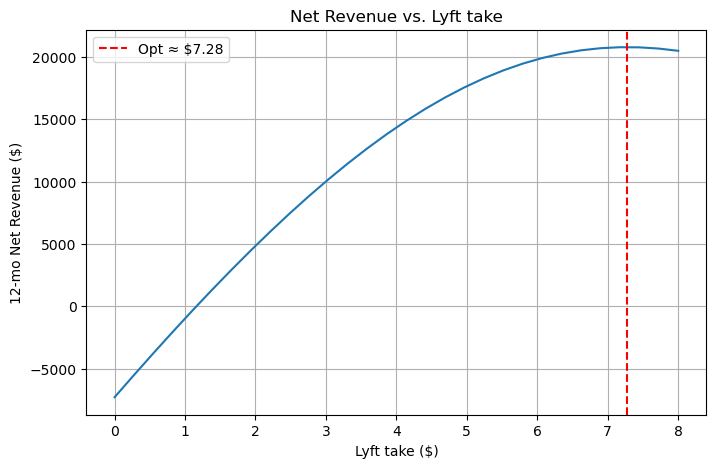

In [14]:
grid = np.linspace(0, 8, 30)
net_vals = [simulate_12m(t) for t in grid]
plt.plot(grid, net_vals)
plt.axvline(opt_take, color='red', linestyle='--', label=f'Opt ≈ ${opt_take:.2f}')
plt.xlabel("Lyft take ($)"); plt.ylabel("12-mo Net Revenue ($)")
plt.title("Net Revenue vs. Lyft take"); plt.grid(True); plt.legend(); plt.show()


In [16]:
def bandit_pay(initial_take=7.0, horizon=12, step=0.25, target=0.90):
    take = initial_take
    takes, matches = [], []
    for _ in range(horizon):
        m = match_rate(take)
        # Simple rule: if below target, reduce take; above, increase
        if m < target:   take = max(0, take - step)
        elif m > target+0.05: take = min(8, take + step)
        takes.append(take); matches.append(m)
    return pd.DataFrame({'month':range(1,horizon+1), 'take':takes, 'match':matches})


In [18]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize_scalar
plt.rcParams["figure.figsize"] = (8,5)

# ── observed (take $, match-rate) pairs ────────────────────────────────────────
data_points = np.array([
    (8.0, 0.70),   # launch
    (4.0, 0.88),   # first experiment
])
takes_obs, matches_obs = data_points[:,0], data_points[:,1]


C:\Users\DELL\AppData\Local\Temp\ipykernel_15248\3542449127.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  a, b = curve_fit(logistic, takes_obs, matches_obs, p0=[a_init, b_init])[0]
C:\Users\DELL\AppData\Local\Temp\ipykernel_15248\3542449127.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  a_i, b_i = curve_fit(logistic, takes_obs, y_noisy, p0=[a_init, b_init])[0]


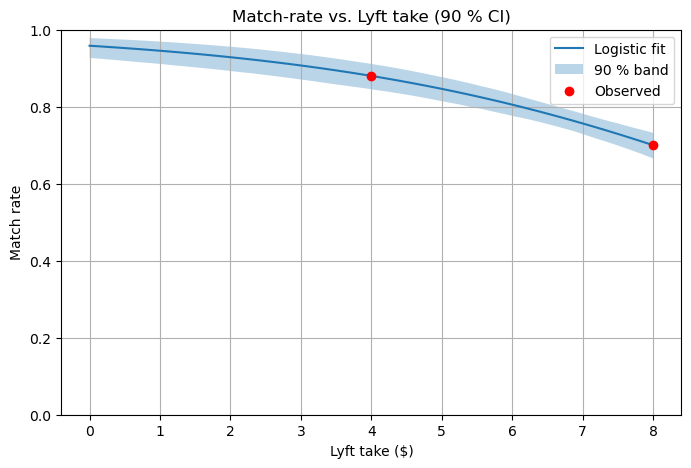

In [20]:
def logistic(x, a, b):               # match(take) = 1 / (1 + e^{-(a + b·take)})
    return 1 / (1 + np.exp(-(a + b * x)))

def logit(y): return np.log(y / (1-y))

# quick 2-point initial guess
(p1,m1), (p2,m2) = data_points
b_init = (logit(m2) - logit(m1)) / (p2 - p1)
a_init = logit(m1) - b_init * p1

# regression (works for ≥2 points)
a, b = curve_fit(logistic, takes_obs, matches_obs, p0=[a_init, b_init])[0]

match_rate = lambda t: logistic(t, a, b)

# ── bootstrap confidence band ─────────────────────────────────────────────────
N_BOOT = 1_000               # how many resamples
grid   = np.linspace(0, 8, 50)
boot_pred = np.zeros((N_BOOT, len(grid)))
rng = np.random.default_rng(42)

for i in range(N_BOOT):
    noise = rng.normal(0, 0.02, size=matches_obs.shape)      # ±2 pp measurement error
    y_noisy = np.clip(matches_obs + noise, 0.01, 0.99)
    try:
        a_i, b_i = curve_fit(logistic, takes_obs, y_noisy, p0=[a_init, b_init])[0]
    except RuntimeError:          # fallback if fit fails
        a_i, b_i = a_init, b_init
    boot_pred[i] = logistic(grid, a_i, b_i)

lower, upper = np.percentile(boot_pred, [5, 95], axis=0)

# ── plot ───────────────────────────────────────────────────────────────────────
plt.plot(grid, match_rate(grid), label="Logistic fit")
plt.fill_between(grid, lower, upper, alpha=0.3, label="90 % band")
plt.scatter(takes_obs, matches_obs, color="red", zorder=5, label="Observed")
plt.xlabel("Lyft take ($)"); plt.ylabel("Match rate"); plt.ylim(0,1)
plt.title("Match-rate vs. Lyft take (90 % CI)"); plt.grid(True); plt.legend()
plt.show()


In [38]:
FARE = 35
GOOD_RIDER_CHURN, BAD_RIDER_CHURN = 0.10, 0.38
SEED_RIDERS, SEED_DRIVERS = 1_000, 80          # tweak freely

def driver_cac(n, slope_factor):
    """Linear CAC curve, scaled by slope_factor."""
    return np.interp(n, [0, 1_000], [600 * slope_factor, 400 * slope_factor])

def rider_cac(n):
    return np.interp(n, [0, 10_000], [20, 10])

def simulate_12m(take, driver_churn=0.05, slope_factor=1.0):
    riders, drivers, net = SEED_RIDERS, SEED_DRIVERS, 0
    for _ in range(12):
        fulfilled = riders * match_rate(take)
        net += take * fulfilled
        net -= driver_cac(drivers, slope_factor)
        net -= rider_cac(riders)
        riders *= 1 - (BAD_RIDER_CHURN * (1 - match_rate(take))
                       + GOOD_RIDER_CHURN * match_rate(take))
        drivers *= 1 - driver_churn
    return net

def optimal_take(driver_churn=0.05, slope_factor=1.0):
    res = minimize_scalar(lambda x: -simulate_12m(x, driver_churn, slope_factor),
                          bounds=(0, 8), method='bounded')
    return res.x


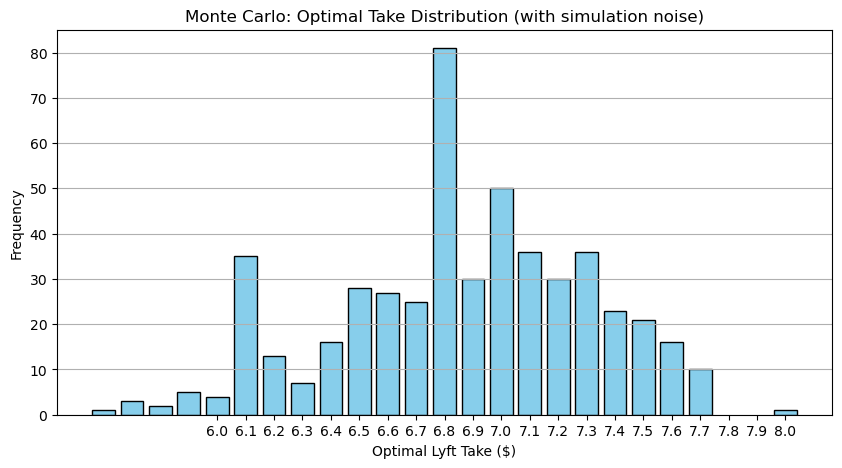

Most frequent optimal take: $6.80


In [36]:
def simulate_12m_noisy(take, driver_churn=0.05, slope_factor=1.0, noise=0.02):
    riders, drivers, net = SEED_RIDERS, SEED_DRIVERS, 0
    for _ in range(12):
        base_match = match_rate(take)
        match = np.clip(np.random.normal(base_match, noise), 0, 1)
        fulfilled = riders * match
        net += take * fulfilled
        net -= driver_cac(drivers, slope_factor)
        net -= rider_cac(riders)
        riders *= 1 - (BAD_RIDER_CHURN * (1 - match) + GOOD_RIDER_CHURN * match)
        drivers *= 1 - driver_churn
    return net

# Re-run Monte Carlo with added noise
MC = 500
optimates = []

np.random.seed(42)
for _ in range(MC):
    churn = np.random.uniform(0.02, 0.08)
    slope = np.random.uniform(0.7, 1.3)
    res = minimize_scalar(lambda x: -simulate_12m_noisy(x, churn, slope, noise=0.02),
                          bounds=(0, 8), method='bounded')
    optimates.append(res.x)

# Group by $0.10
rounded = np.round(optimates, 1)
unique_takes, counts = np.unique(rounded, return_counts=True)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(unique_takes, counts, width=0.08, color='skyblue', edgecolor='black')
plt.xlabel("Optimal Lyft Take ($)")
plt.ylabel("Frequency")
plt.title("Monte Carlo: Optimal Take Distribution (with simulation noise)")
plt.xticks(np.arange(6.0, 8.1, 0.1))
plt.grid(axis='y')
plt.show()

# Summary
mode_take = unique_takes[np.argmax(counts)]
print(f"Most frequent optimal take: ${mode_take:.2f}")


In [54]:
import numpy as np

mean_take = np.mean(takes)
median_take = np.median(takes)
std_dev = np.std(takes)
iqr = np.percentile(takes, 75) - np.percentile(takes, 25)

print(f"Mean: ${mean_take:.2f}")
print(f"Median: ${median_take:.2f}")
print(f"Standard Deviation: ${std_dev:.2f}")
print(f"IQR: ${iqr:.2f}")


Mean: $4.00
Median: $4.00
Standard Deviation: $2.38
IQR: $4.00


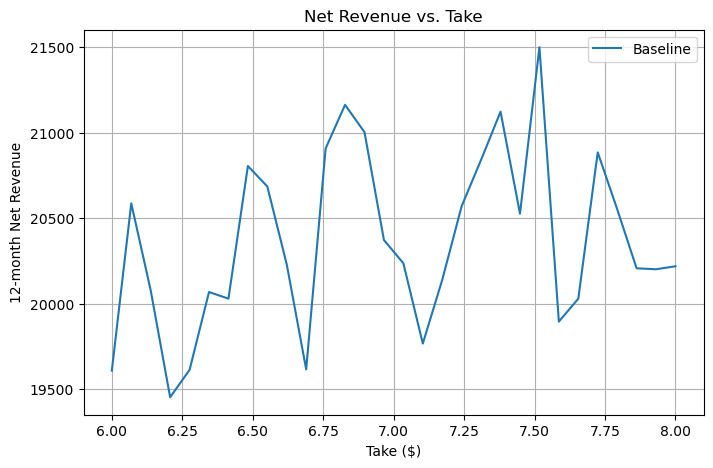

In [46]:
takes_grid = np.linspace(6, 8, 30)
revenues = [simulate_12m_noisy(t, driver_churn=0.05, slope_factor=1.0) for t in takes_grid]

plt.plot(takes_grid, revenues, label='Baseline')
plt.title("Net Revenue vs. Take")
plt.xlabel("Take ($)")
plt.ylabel("12-month Net Revenue")
plt.grid(True)
plt.legend()
plt.show()


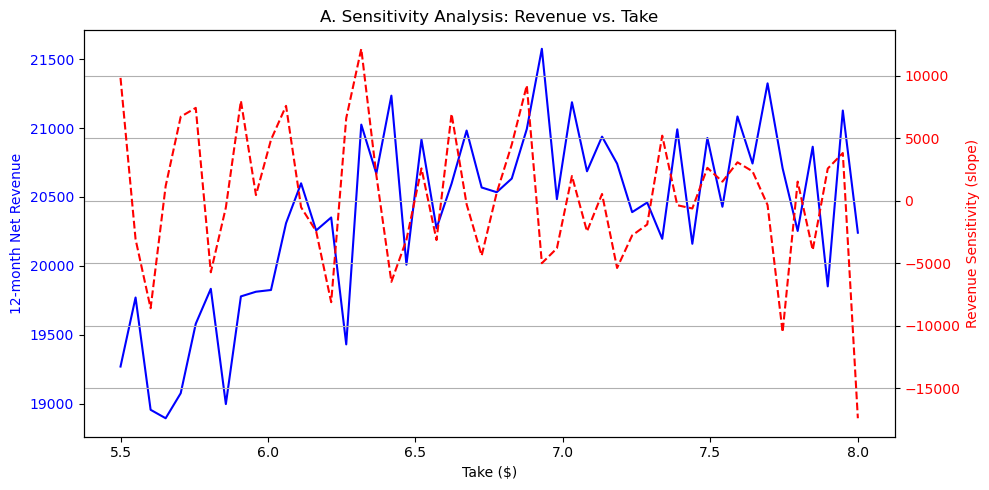

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Grid of take values to test
takes_grid = np.linspace(5.5, 8.0, 50)

# Calculate net revenue for each take using noisy simulation
revenues = [simulate_12m_noisy(t) for t in takes_grid]

# Calculate the slope (sensitivity) using numerical gradient
slopes = np.gradient(revenues, takes_grid)

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot revenue vs take (primary y-axis)
ax1.plot(takes_grid, revenues, color='blue', label='Net Revenue')
ax1.set_xlabel("Take ($)")
ax1.set_ylabel("12-month Net Revenue", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("A. Sensitivity Analysis: Revenue vs. Take")

# Plot slope on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(takes_grid, slopes, color='red', linestyle='--', label='Revenue Sensitivity')
ax2.set_ylabel("Revenue Sensitivity (slope)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Grid and layout
fig.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
''' 
Sensitivity Analysis Result:

The blue curve shows net revenue across different take values.

The red dashed line is the slope (how fast revenue changes) — your sensitivity indicator.

Insight:
Revenue is relatively flat (stable) between $6.7 and $7.2

Sharp drop below ~$6 — this is a risk zone

Above ~$7.5, slope flattens again — increasing take has diminishing returns
'''

In [74]:
# Function to simulate 1-month profit for a given match rate
def simulate_monthly_profit(match, take=6.0, riders=1000, drivers=80, slope_factor=1.0):
    """
    Simulate monthly profit assuming a given match rate.
    Uses fixed take, rider and driver values.
    """
    fulfilled = match * riders
    revenue = take * fulfilled
    cost = driver_cac(drivers, slope_factor) + rider_cac(riders)
    profit = revenue - cost
    return profit

# Match rate scenarios
match_low = 0.70
match_high = 0.90

# Simulate profits
profit_low = simulate_monthly_profit(match_low)
profit_high = simulate_monthly_profit(match_high)
roi_gain = profit_high - profit_low

# Display the results
print(f"Monthly profit at 70% match rate: ${profit_low:,.2f}")
print(f"Monthly profit at 90% match rate: ${profit_high:,.2f}")
print(f"Profit increase from boosting match rate: ${roi_gain:,.2f}")
print(f"ROI Justification: Investing in driver acquisition to raise match rate from 70% to 90% yields an extra ${roi_gain:,.0f}/mo.")


Monthly profit at 70% match rate: $3,597.00
Monthly profit at 90% match rate: $4,797.00
Profit increase from boosting match rate: $1,200.00
ROI Justification: Investing in driver acquisition to raise match rate from 70% to 90% yields an extra $1,200/mo.


In [98]:
def simulate_monthly_profit_realistic(match, take=6.0, riders=1000, drivers=80):
    """
    More realistic profit estimation:
    - Fulfillment limited by driver capacity
    - CAC changes based on match experience
    - Retention effects simulated
    """

    # Driver capacity: max 100 rides per driver
    max_possible_rides = drivers * 100
    potential_rides = match * riders
    fulfilled = min(potential_rides, max_possible_rides)

    # Revenue
    revenue = take * fulfilled

    # CAC increases if match rate is bad (below 75%)
    rider_cac_value = 20 if match < 0.75 else 12
    driver_cac_value = 500 if match < 0.75 else 400

    # Apply churn-adjusted retention benefit
    if match >= 0.90:
        retention_boost = 1.1
    elif match <= 0.70:
        retention_boost = 0.85
    else:
        retention_boost = 1.0

    net_profit = (revenue - (driver_cac_value + rider_cac_value)) * retention_boost

    return net_profit


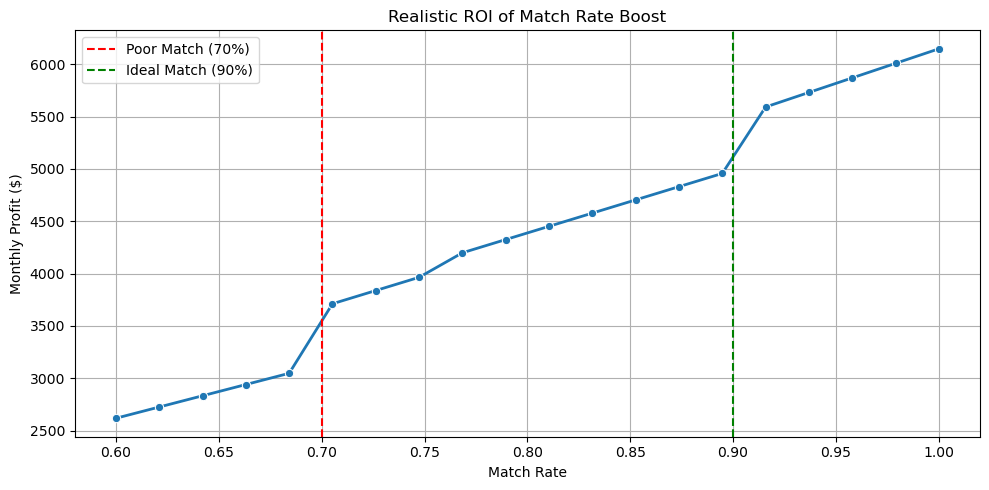

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Match rates to test
match_rates = np.linspace(0.6, 1.0, 20)
profits_realistic = [simulate_monthly_profit_realistic(m) for m in match_rates]

# Create DataFrame
df_realistic = pd.DataFrame({
    'Match Rate': match_rates,
    'Realistic Monthly Profit ($)': profits_realistic
})

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_realistic, x='Match Rate', y='Realistic Monthly Profit ($)', marker='o', linewidth=2)
plt.axvline(0.70, color='red', linestyle='--', label='Poor Match (70%)')
plt.axvline(0.90, color='green', linestyle='--', label='Ideal Match (90%)')
plt.title("Realistic ROI of Match Rate Boost")
plt.xlabel("Match Rate")
plt.ylabel("Monthly Profit ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


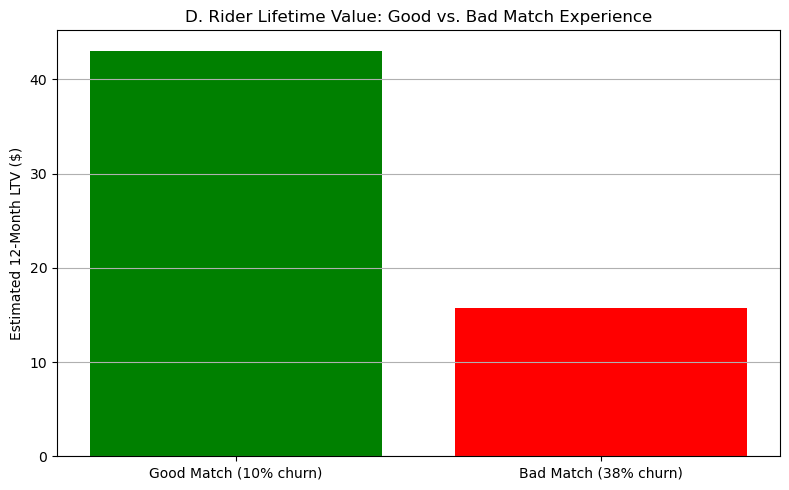

Minimum take to break even: $0.00
Estimated net profit at break-even take: $-7285.61


In [88]:
# === Function to Estimate LTV ===
def estimate_ltv(churn_rate, rides_per_month=1, months=12, revenue_per_ride=6.0):
    """
    Estimate the 12-month LTV of a rider based on churn rate.
    """
    total_value = 0
    active_riders = 1
    for _ in range(months):
        month_value = active_riders * rides_per_month * revenue_per_ride
        total_value += month_value
        active_riders *= (1 - churn_rate)
    return total_value

# === LTV for Good vs. Bad Match ===
GOOD_RIDER_CHURN = 0.10
BAD_RIDER_CHURN = 0.38

ltv_good = estimate_ltv(GOOD_RIDER_CHURN)
ltv_bad = estimate_ltv(BAD_RIDER_CHURN)

# === Bar Chart Comparison ===
import matplotlib.pyplot as plt

ltv_data = {
    'Good Match (10% churn)': ltv_good,
    'Bad Match (38% churn)': ltv_bad
}

plt.figure(figsize=(8, 5))
plt.bar(ltv_data.keys(), ltv_data.values(), color=['green', 'red'])
plt.title("D. Rider Lifetime Value: Good vs. Bad Match Experience")
plt.ylabel("Estimated 12-Month LTV ($)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# === E. Break-even Take Threshold ===
from scipy.optimize import minimize_scalar

def simulate_12m_noisy_human(take, driver_churn=0.05, slope_factor=1.0, noise=0.02):
    riders = 1000
    drivers = 80
    net_profit = 0
    for _ in range(12):
        base_match = match_rate(take)
        match = np.clip(np.random.normal(base_match, noise), 0, 1)
        fulfilled = riders * match
        revenue = take * fulfilled
        cost = driver_cac(drivers, slope_factor) + rider_cac(riders)
        net_profit += revenue - cost
        churn_rate = BAD_RIDER_CHURN * (1 - match) + GOOD_RIDER_CHURN * match
        riders *= (1 - churn_rate)
        drivers *= (1 - driver_churn)
    return net_profit

# Minimize scalar search for break-even threshold
result = minimize_scalar(
    lambda t: simulate_12m_noisy_human(t),
    bounds=(0, 8),
    method='bounded'
)

break_even_take = result.x
break_even_profit = simulate_12m_noisy_human(break_even_take)

print(f"Minimum take to break even: ${break_even_take:.2f}")
print(f"Estimated net profit at break-even take: ${break_even_profit:.2f}")


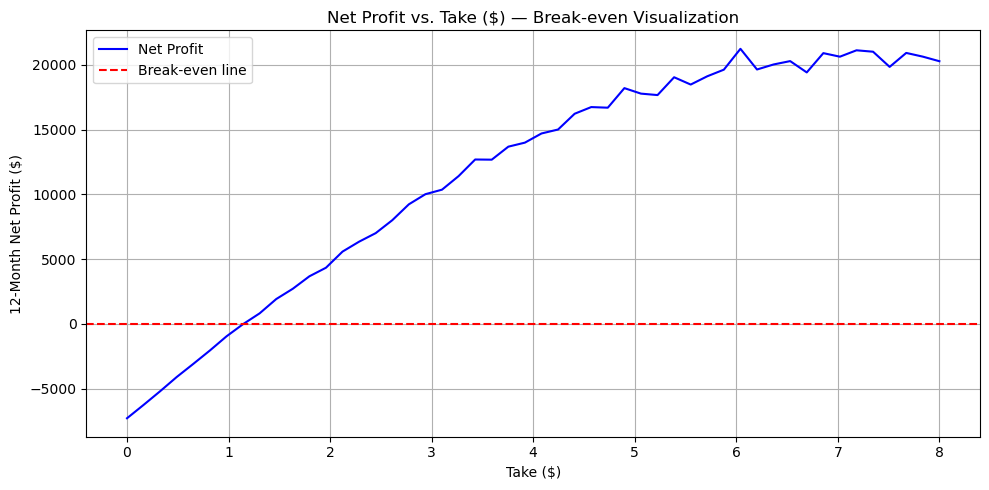

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Sweep a range of take values between $0 and $8
take_range = np.linspace(0, 8, 50)

# Simulate 12-month profit for each take value using the noisy model
profits = [simulate_12m_noisy_human(take) for take in take_range]

# Plot the net profit curve
plt.figure(figsize=(10, 5))
plt.plot(take_range, profits, color='blue', label='Net Profit')
plt.axhline(0, color='red', linestyle='--', label='Break-even line')

# Add labels and formatting
plt.title("Net Profit vs. Take ($) — Break-even Visualization")
plt.xlabel("Take ($)")
plt.ylabel("12-Month Net Profit ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


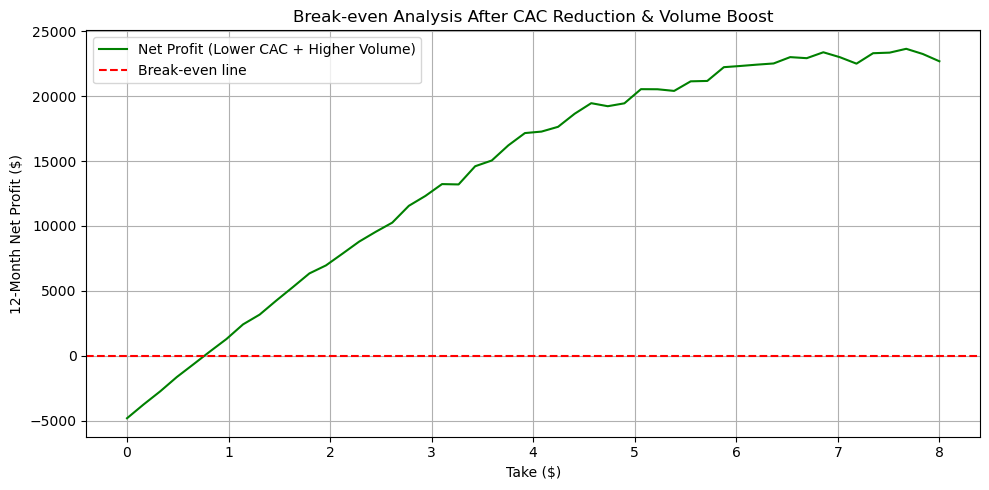

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Re-define CAC functions with lower costs to simulate scale efficiency
def driver_cac(n_drivers, slope=1.0):
    # Lower driver CAC: from 400–600 → 200–400
    return np.interp(n_drivers, [0, 1000], [400 * slope, 200 * slope])

def rider_cac(n_riders):
    # Lower rider CAC: from 10–20 → 5–15
    return np.interp(n_riders, [0, 10000], [15, 5])

# Redefine seed volume (scale benefit)
SEED_RIDERS = 2000   # double the riders
SEED_DRIVERS = 100   # slightly more drivers

# Reuse simulate_12m_noisy_human from earlier
# Make sure this function uses SEED_RIDERS and SEED_DRIVERS

# Sweep take values and calculate net profits under scaled scenario
take_range_scaled = np.linspace(0, 8, 50)
profits_scaled = [simulate_12m_noisy_human(take) for take in take_range_scaled]

# Plot the updated profit curve
plt.figure(figsize=(10, 5))
plt.plot(take_range_scaled, profits_scaled, color='green', label='Net Profit (Lower CAC + Higher Volume)')
plt.axhline(0, color='red', linestyle='--', label='Break-even line')

plt.title("Break-even Analysis After CAC Reduction & Volume Boost")
plt.xlabel("Take ($)")
plt.ylabel("12-Month Net Profit ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [96]:
# Assumptions
current_churn = 0.10
improved_churn = 0.07
rider_base = 10_000
revenue_per_ride = 6.0
rides_per_month = 1
months = 12

# Estimate LTV
def estimate_ltv(churn_rate, rides_per_month=1, months=12, revenue_per_ride=6.0):
    total_value = 0
    active_riders = 1
    for _ in range(months):
        total_value += active_riders * rides_per_month * revenue_per_ride
        active_riders *= (1 - churn_rate)
    return total_value

ltv_current = estimate_ltv(current_churn, rides_per_month, months, revenue_per_ride)
ltv_improved = estimate_ltv(improved_churn, rides_per_month, months, revenue_per_ride)

# Revenue and gain
revenue_current = ltv_current * rider_base
revenue_improved = ltv_improved * rider_base
revenue_gain = revenue_improved - revenue_current

# Assume CAC is constant
rider_cac = 12  # average acquisition cost per rider
profit_current = revenue_current - (rider_cac * rider_base)
profit_improved = revenue_improved - (rider_cac * rider_base)
profit_gain = profit_improved - profit_current

# Optional: ROI if we spend $10K to reduce churn by 3%
churn_reduction_investment = 10_000
roi = profit_gain / churn_reduction_investment if churn_reduction_investment > 0 else None

# Display Results
print(f"Total revenue (current churn): ${revenue_current:,.2f}")
print(f"Total revenue (improved churn): ${revenue_improved:,.2f}")
print(f"Revenue uplift from churn reduction: ${revenue_gain:,.2f}")

print(f"Total profit uplift: ${profit_gain:,.2f}")
if roi:
    print(f"ROI on $10K churn-reduction investment: {roi:.2f}x")


Total revenue (current churn): $430,542.28
Total revenue (improved churn): $498,346.03
Revenue uplift from churn reduction: $67,803.75
Total profit uplift: $67,803.75
ROI on $10K churn-reduction investment: 6.78x
